In [1]:
import numpy as np
import pandas as pd
import shap
import xgboost
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
shap.initjs() # Don't worry if this doesn't work for you. Comment it out and carry on

In [13]:
if int(tf.__version__[2]) > 3:
    print("Tensorflow version above 2.3.1 has an (as of now) unsolved bug which affects the graph part of SHAP.")
    print("Please downgrade if you have 2.4.0")
    print("See also https://github.com/onnx/keras-onnx/issues/651")
    print("If you don't want to downgrade, you can run everything up to the MNIST part")

Tensorflow version above 2.3.1 has an (as of now) unsolved bug which affects the graph part of SHAP.
Please downgrade if you have 2.4.0
See also https://github.com/onnx/keras-onnx/issues/651


# Part 1: Boston Housing

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()
#print(boston.DESCR) # print feature descriptions
#print(boston.keys()) # print all keys
#print(boston.feature_names) # print all feature names

In [3]:
boston_dataset = pd.DataFrame(boston.data, columns=boston.feature_names)
boston_dataset["MEDV"] =  boston.target

# Subset of features for computation time and brain power (Rooms, age, tax and crime rate)
features_to_use = ["RM", "AGE", "TAX", "CRIM", "PTRATIO"]
x_data = boston_dataset[features_to_use]
y_data = boston_dataset.MEDV

# I also love np arrays, but keep the dataframe structure if you want feature names on your SHAP plot

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42)

Average rooms:  6.284634387351779
Average age:  68.57490118577076
Average tax rate:  408.2371541501976
Average crime rate:  3.613523557312254
Average price in 1000$:  22.532806324110677


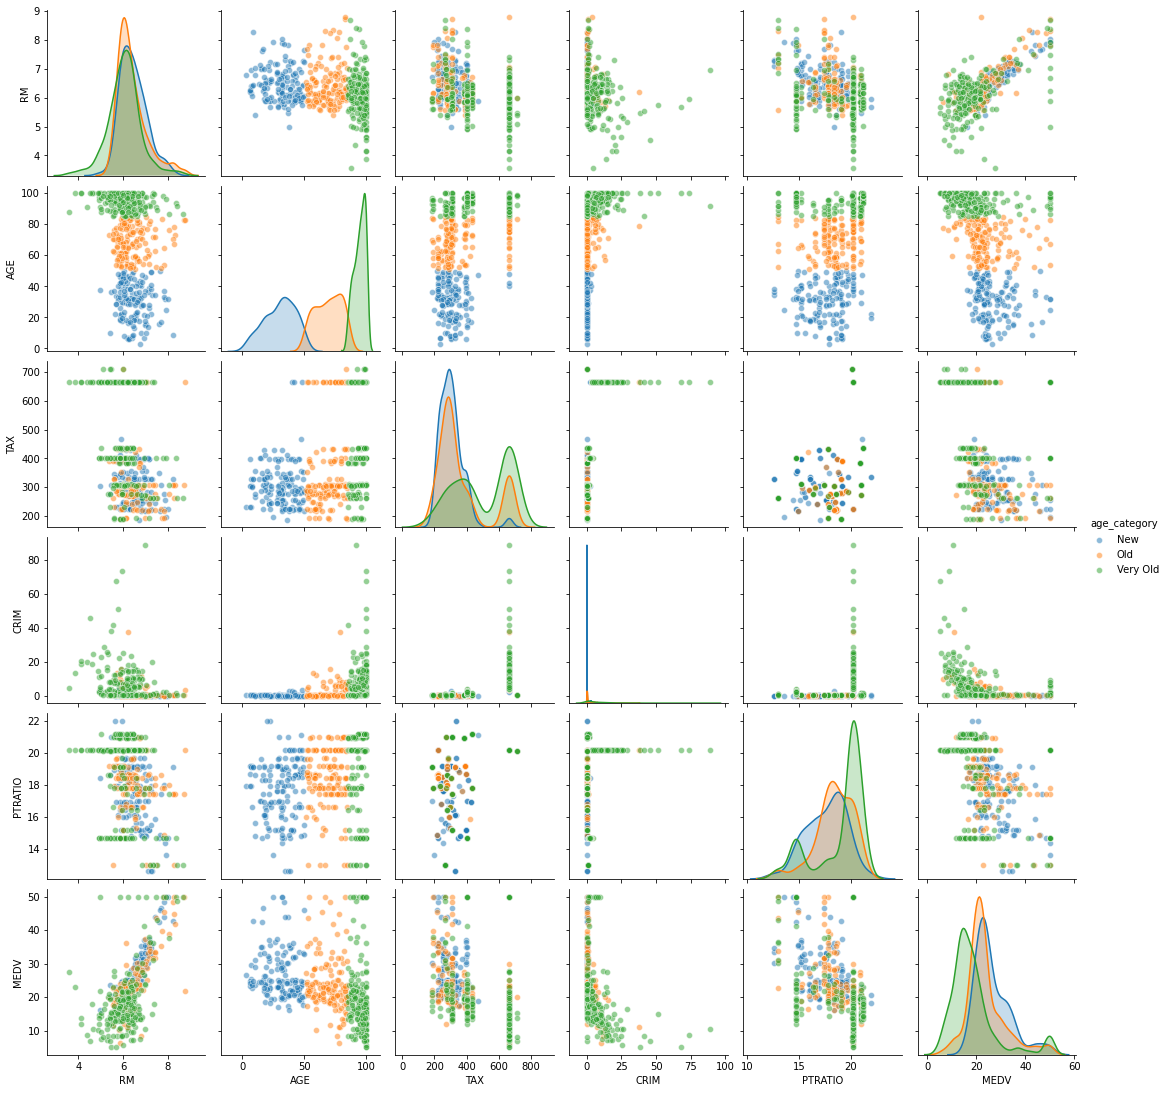

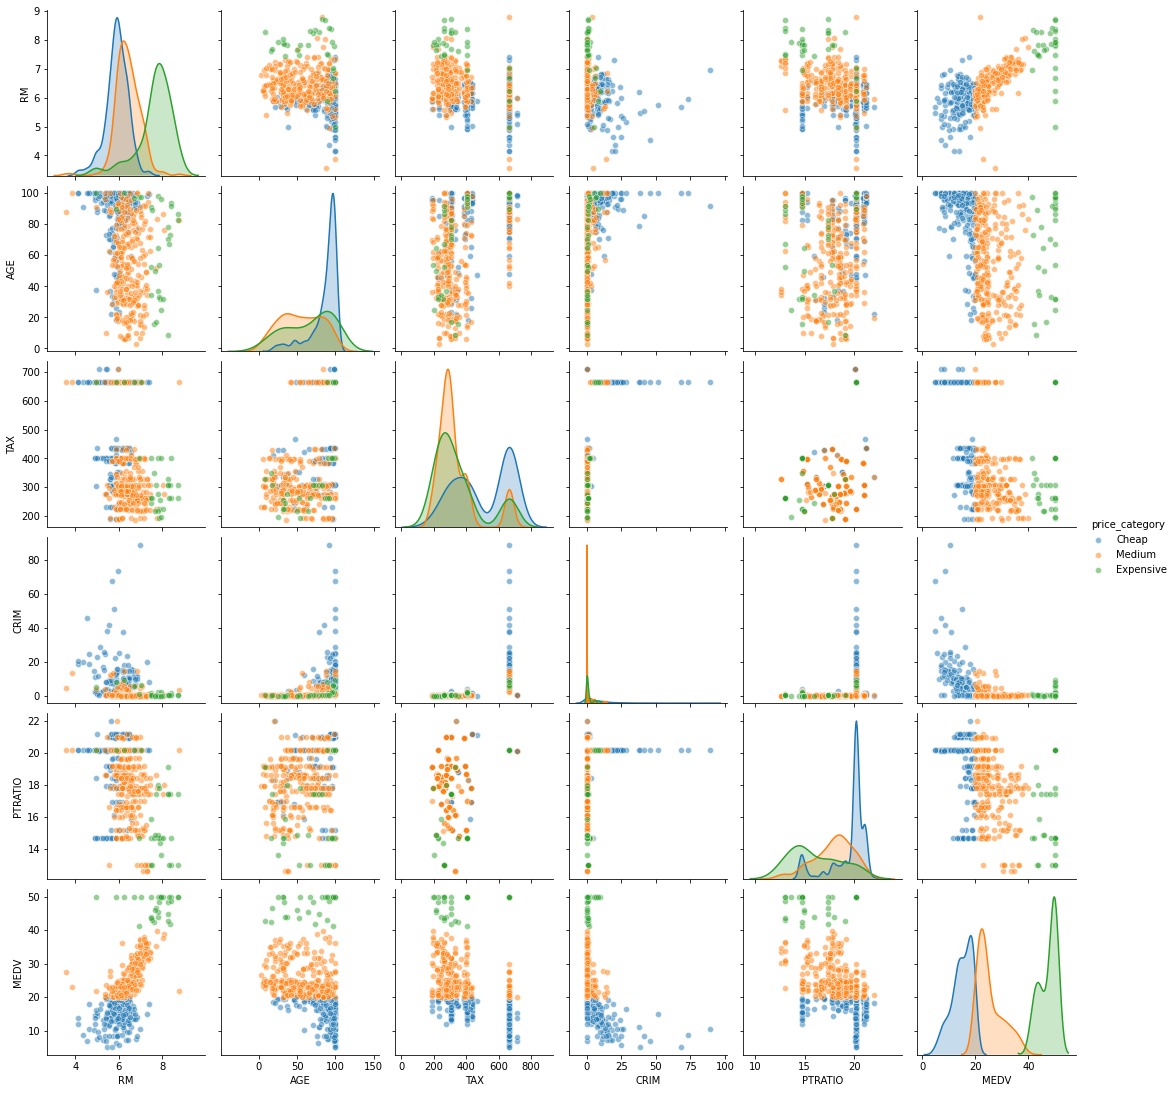

In [4]:
# Look at the data (this cell is optional and takes a while to run)

# Make dataframe to play with
df = boston_dataset.copy()
cols = features_to_use.copy()
cols.extend(["MEDV"])

def make_price_categories(x):
    if x < 20:
        return "Cheap"
    elif 20 <= x < 40:
        return "Medium"
    else:
        return "Expensive"
    
def make_age_categories(x):
    if x < 50:
        return "New"
    elif 50 <= x < 85:
        return "Old"
    else:
        return "Very Old"
    
print("Average rooms: ", np.average(df.RM))
print("Average age: ", np.average(df.AGE))
print("Average tax rate: ", np.average(df.TAX))
print("Average crime rate: ", np.average(df.CRIM))
print("Average price in 1000$: ", np.average(df.MEDV))

# Look at age behaviour
df["age_category"] = df.AGE.apply(make_age_categories)
age_cols = cols.copy()
age_cols.extend(["age_category"])
sns.pairplot(df[age_cols], hue='age_category',
             hue_order=['New', 'Old', 'Very Old'],
             plot_kws={'alpha': 0.5})
plt.show()

# Look at price behaviour
df["price_category"] = df.MEDV.apply(make_price_categories)
price_cols = cols.copy()
price_cols.extend(["price_category"]) # subset of features
sns.pairplot(df[price_cols], hue='price_category',
             hue_order=['Cheap', 'Medium', 'Expensive'],
             plot_kws={'alpha': 0.5})

plt.show()

In [5]:
# Train an XGBoost Regressor to predict price (MEDV = median value in 1000$)
regressor = xgboost.XGBRegressor()
regressor.fit(x_train, y_train);

## Task 1: SHAP explainations for housing prices

In [6]:
# Initialise explainer on a background data set, the data parameter.
# (this is the data that data to ble explained is compared against when calculating SHAP values)
explainer = shap.TreeExplainer(regressor, data=x_train) 

# Calculate SHAP values
shap_values = explainer.shap_values(x_test) #n_samples=100

In [7]:
# Pick an instance to look closer at
y_pred = regressor.predict(x_test)
print("Mean price: ", np.mean(y_test))
print("Mean price prediction: ", np.mean(y_pred))

print("Mean crime rate: ", np.mean(x_test.CRIM))

# i = 6: Old house where only the low crime rate helps push the price up
i=6
print(x_test.iloc[i])
print("Actual price: ", y_test.iloc[i])
print("Predicted price: ", y_pred[i])
shap.force_plot(explainer.expected_value, shap_values[i,:], x_test.iloc[i,:])

Mean price:  21.643712574850298
Mean price prediction:  21.19433
Mean crime rate:  4.1457728143712576
RM           5.91400
AGE         83.20000
TAX        304.00000
CRIM         0.31827
PTRATIO     18.40000
Name: 316, dtype: float64
Actual price:  17.8
Predicted price:  19.04583


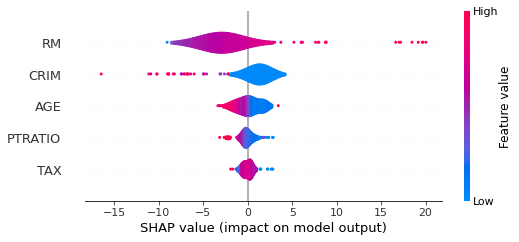

In [8]:
shap.summary_plot(shap_values, x_test, plot_type="violin")

In [9]:
# Sanity stuff

# The model is trained on y_data.shape[0] instances, which each get SHAP values
print(f"Number of instances: {len(shap_values)} (=={y_test.shape[0]})")

# The model has x_data.shape[1] input features, which each get one SHAP value
print(f"Number of SHAP values per instance: {len(shap_values[0])} (=={x_test.shape[1]})")

# SHAP values tell you how much the features drive the prediction away from the mean, which is
mean_pred_gbt = np.mean(regressor.predict(x_train)) # NOTE: On the background set for SHAP
print(f"Mean prediction over data set: {mean_pred_gbt} (approx= {explainer.expected_value})")
# Sanity check: mean model prediction and expected value according to the SHAP explainer should be the same

Number of instances: 167 (==167)
Number of SHAP values per instance: 5 (==5)
Mean prediction over data set: 22.970840454101562 (approx= 22.970845232915245)


# Part 2: SHAP on MNIST

In [10]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

(x_train_raw, y_train), (x_test_raw, y_test) = mnist.load_data()

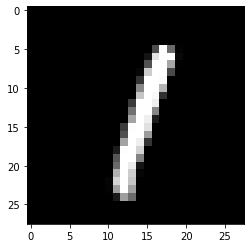

In [11]:
# Just for looking at images
from matplotlib import pyplot
pyplot.imshow(x_test_raw[5], cmap=pyplot.get_cmap('gray'))
pyplot.show()

In [13]:
# Input image dimensions
img_rows, img_cols = 28, 28

num_classes = 10

x_train = x_train_raw.reshape(x_train_raw.shape[0], img_rows, img_cols, 1)
x_test = x_test_raw.reshape(x_test_raw.shape[0], img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert vectors to binary matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [14]:
# Model architecture borrowed from https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

input_shape = (img_rows, img_cols, 1)
batch_size = 128
epochs = 12

mnist_model = Sequential()
mnist_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
mnist_model.add(Conv2D(64, (3, 3), activation='relu'))
mnist_model.add(MaxPooling2D(pool_size=(2, 2)))
mnist_model.add(Dropout(0.25))
mnist_model.add(Flatten())
mnist_model.add(Dense(128, activation='relu'))
mnist_model.add(Dropout(0.5))
mnist_model.add(Dense(num_classes, activation='softmax'))

mnist_model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

mnist_model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
score = mnist_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/12
469/469 [==============================] - 64s 137ms/step - loss: 2.2755 - accuracy: 0.1552 - val_loss: 2.2404 - val_accuracy: 0.3178
Epoch 2/12
469/469 [==============================] - 60s 127ms/step - loss: 2.2174 - accuracy: 0.2663 - val_loss: 2.1686 - val_accuracy: 0.5433
Epoch 3/12
469/469 [==============================] - 61s 131ms/step - loss: 2.1408 - accuracy: 0.3761 - val_loss: 2.0693 - val_accuracy: 0.6567
Epoch 4/12
469/469 [==============================] - 60s 129ms/step - loss: 2.0354 - accuracy: 0.4647 - val_loss: 1.9340 - val_accuracy: 0.7177
Epoch 5/12
469/469 [==============================] - 61s 130ms/step - loss: 1.8958 - accuracy: 0.5364 - val_loss: 1.7610 - val_accuracy: 0.7519
Epoch 6/12
469/469 [==============================] - 60s 128ms/step - loss: 1.7306 - accuracy: 0.5801 - val_loss: 1.5566 - val_accuracy: 0.7751
Epoch 7/12
469/469 [==============================] - 64s 137ms/step - loss: 1.5545 - accuracy: 0.6129 - val_loss: 1.3442 - val_ac

In [16]:
# Pick 100 random background images from the train set, to calculate the expectation
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# Create DeepExplainer instance on model and background
image_explainer = shap.DeepExplainer(mnist_model, background);

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


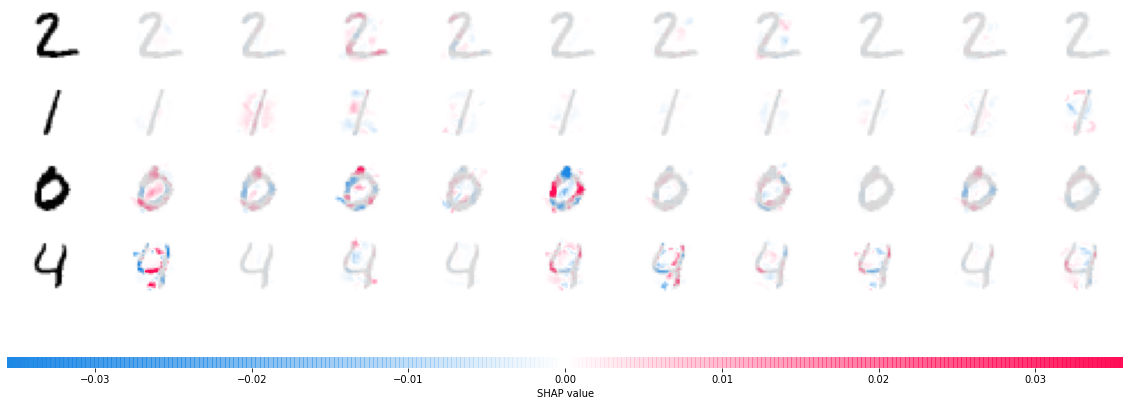

In [17]:
# Pick images to calculate SHAP values for
images = x_test[1:5]

# calculate SHAP values and plot them
shap_values = image_explainer.shap_values(images)
shap.image_plot(shap_values, -images)